In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import brewer2mpl
import colorsys
import math

from datetime import datetime
from Bio import AlignIO, SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Levenshtein import distance
from itertools import combinations, product
from time import time
from __future__ import division
from collections import Counter
from copy import deepcopy
from random import shuffle, choice, sample
from scipy.stats.mstats import mquantiles
from scipy.stats import norm, expon, poisson
from scipy.misc import comb
from IPython.display import Math
%matplotlib inline

In [2]:
# Sequences from Holmes05 as a test case
sequences = SeqIO.to_dict(SeqIO.parse('20141121 PB2 Global Analysis.fasta', 'fasta'))
sequences

{'CY123822': SeqRecord(seq=Seq('MERIKELRDLMSQSRTREILTKTTVDHMAIIKKYTSGRQEKNPALRMKWMMAMR...AIN', SingleLetterAlphabet()), id='CY123822', name='CY123822', description='CY123822', dbxrefs=[]),
 'CY003047': SeqRecord(seq=Seq('MERIKELRNLMSQSRTREILTKTTVDHMAIIKKYTSGRQEKNPSLRMKWMMAMK...AIN', SingleLetterAlphabet()), id='CY003047', name='CY003047', description='CY003047', dbxrefs=[]),
 'CY166289': SeqRecord(seq=Seq('MERIKELRDLMSQSRTREILTKTTVDHMAIIKKYTSGRQEKNPALRMKWMMAMK...AIN', SingleLetterAlphabet()), id='CY166289', name='CY166289', description='CY166289', dbxrefs=[]),
 'CY130940': SeqRecord(seq=Seq('MERIKELRDLMSQSRTREILTKTTVDHMAIIKKYTSGRQEKNPALRMKWMMAMK...AIN', SingleLetterAlphabet()), id='CY130940', name='CY130940', description='CY130940', dbxrefs=[]),
 'CY142433': SeqRecord(seq=Seq('MDRIKELRDLMSQSRTREILTKTTVDHMAIIKKYTSGRQEKNPALRMKWMMAMK...AIN', SingleLetterAlphabet()), id='CY142433', name='CY142433', description='CY142433', dbxrefs=[]),
 'CY089306': SeqRecord(seq=Seq('MERIKELRDLMSQSRTREILTKT

In [3]:
# Function to find longest ORFs:
def longest_orfs(list_of_seqrecords):
    aa_sequences = []
    for i, record in enumerate(list_of_seqrecords):
        longest_protein = SeqRecord(id=record.id, seq='')
        for frame in range(3):
            length = 3 * ((len(record) - frame) // 3)
            translation = record.seq[frame:frame + length].translate()
            for pro in translation.split("*"):
                if len(pro) > len(longest_protein.seq):
                    longest_protein.seq = pro
                    
        longest_protein.seq = longest_protein.seq[str(longest_protein.seq).index('M'):]
        aa_sequences.append(longest_protein)
        
    return aa_sequences

In [4]:
pb2_sequences = sequences
# print(pb2_sequences)

pb2_lengths = [len(sequence.seq) for accession, sequence in pb2_sequences.items()]
most_common_length = Counter(pb2_lengths).most_common(1)[0][0]
print(most_common_length)

# To avoid doing a multiple sequence alignment, we will only consider those of the most common length.
pb2_sequences_filtered = dict()
for accession, seqrecord in pb2_sequences.items():
    if len(seqrecord.seq) == most_common_length:
        pb2_sequences_filtered[accession] = seqrecord
        
pb2_sequences = pb2_sequences_filtered

759


In [5]:
Counter(pb2_lengths).most_common()

[(759, 23917),
 (760, 15),
 (758, 11),
 (768, 5),
 (761, 5),
 (755, 4),
 (757, 4),
 (765, 3),
 (754, 2),
 (762, 2),
 (763, 2),
 (764, 2),
 (743, 1),
 (729, 1),
 (767, 1)]

In [6]:
# pb2_sequences

In [32]:
data = pd.read_csv('20141121 PB2 Global Analysis.csv', index_col=0, parse_dates=['Collection Date'], na_filter=False)
data = data[data['Segment'] == 1]
data['Sequence Accession'] = data['Sequence Accession'].str.replace('*','')

accession_subtype = dict(zip(data['Sequence Accession'].values, data['Subtype'].values))
accession_subtype['CY136404']

accession_year = dict(zip(data['Sequence Accession'].values, data['Collection Date'].apply(lambda x: x.year)))
# accession_year
accession_host = dict(zip(data['Sequence Accession'].values, data['Host Species'].str.split(':').str[1].values))
accession_host

accession_country = dict(zip(data['Sequence Accession'].values, data['Country'].values))
accession_country

accession_strain = dict(zip(data['Sequence Accession'].values, data['Strain Name'].values))
accession_strain

{'CY123822': 'A/Singapore/ON226/2009',
 'CY003047': 'A/New York/364/2004',
 'CY166289': 'A/mallard/Illinois/11OS5564/2011',
 'CY130940': 'A/swine/Ohio/09SW99/2009',
 'CY142433': 'A/American green-winged teal/Interior Alaska/9BM6223R0/2009',
 'CY089306': 'A/Boston/671/2009',
 'CY172606': 'A/New York/1058/2007',
 'EU880827': 'A/turkey/CA/358533/2005',
 'JX454776': 'A/wild bird/Korea/YS109/2007(H4N6)',
 'CY038678': 'A/Hong Kong/HKU39/2004(H3N2)',
 'CY028362': 'A/Kentucky/UR06-0181/2007',
 'CY039847': 'A/mallard/Interior Alaska/7/2007(H3N8)',
 'CY074706': 'A/Managua/3192.01/2010(H3N2)',
 'KF386768': 'A/swine/Indiana/A01260254/2013',
 'KJ942711': 'A/Ohio/2/2012',
 'CY095219': 'A/unknown/New York/16922/2006(H1N1)',
 'CY079731': 'A/northern pintail/Interior Alaska/6MP0804/2006',
 'CY159184': 'A/swine/North Carolina/00371/2004',
 'CY089338': 'A/Boston/683/2009',
 'KJ568230': 'A/mallard/Ohio/13OS1981/2013',
 'CY081437': 'A/Cambodia/NHRCC00003/2009(H3N2)',
 'CY186527': 'A/mallard/Ohio/12OS1866/2

In [22]:
def get_polymorphisms_at_pos(pos, sequences):
    polymorphisms = [sequence.seq[pos-1] for sequence in sequences]
    return Counter(polymorphisms)

get_polymorphisms_at_pos(591, pb2_sequences.values())

Counter({'H': 28, 'K': 45, 'L': 58, 'P': 3, 'Q': 17200, 'R': 6563, 'X': 20})

In [10]:
def get_sequence_at_pos(pos, seqrecord):
    return seqrecord.seq[pos-1]

polymorphism_subtypes = dict()
polymorphism_hosts = dict()
polymorphism_years = dict()
polymorphism_subtypes_host = dict()
for accession, seqrecord in pb2_sequences.items():
    polymorphisms = (get_sequence_at_pos(590, seqrecord), \
                     get_sequence_at_pos(591, seqrecord))
    
    if polymorphisms not in polymorphism_subtypes.keys():
        polymorphism_subtypes[polymorphisms] = []
        
    if polymorphisms not in polymorphism_hosts.keys():
        polymorphism_hosts[polymorphisms] = []
        
    if polymorphisms not in polymorphism_years.keys():
        polymorphism_years[polymorphisms] = []
        
    if polymorphisms not in polymorphism_subtypes_host.keys():
        polymorphism_subtypes_host[polymorphisms] = []
        
    polymorphism_subtypes[polymorphisms].append((accession_subtype[accession]))
    polymorphism_hosts[polymorphisms].append(accession_host[accession])
    polymorphism_years[polymorphisms].append(accession_year[accession])
    polymorphism_subtypes_host[polymorphisms].append((accession_subtype[accession], accession_host[accession], accession))

In [35]:
# Ad-hoc: 28 September 2015
# Find the K591-containing PB2 that exists in egypt.
map_data = set()
for accession, seqrecord in pb2_sequences.items():
    if get_sequence_at_pos(591, seqrecord) == 'K' and accession_year[seqrecord.id] > 2008:
        map_data.add((accession_country[seqrecord.id], accession_host[seqrecord.id], accession_subtype[seqrecord.id],accession_strain[seqrecord.id]))
map_data

{('China', 'Chicken/Avian', 'H5N2', 'A/chicken/Hebei/1102-MA/2010'),
 ('China', 'Environment', 'H7N9', 'A/environment/Wuxi/1/2013(H7N9)'),
 ('China', 'Human', 'H7N9', 'A/Jiangsu/1/2013'),
 ('China', 'Human', 'H7N9', 'A/Jiangsu/2/2013'),
 ('China', 'Human', 'H7N9', 'A/Nanjing/1/2013'),
 ('China', 'Human', 'H7N9', 'A/Zhejiang/DTID-ZJU08/2013'),
 ('Hong Kong', 'Swine', 'H1N2', 'A/swine/Hong Kong/1479/2009(H1N2)'),
 ('Italy', 'Human', 'H3N2', 'A/Pavia/07/2014'),
 ('Italy', 'Swine', 'H1N1', 'A/swine/Italy/218884-2/2012'),
 ('Italy', 'Swine', 'H3N2', 'A/swine/Italy/187969/2013(H3N2)'),
 ('Italy', 'Swine', 'H3N2', 'A/swine/Italy/250481_2/2013(H3N2)'),
 ('Italy', 'Swine', 'H3N2', 'A/swine/Italy/282811/2013(H3N2)'),
 ('Italy', 'Swine', 'H3N2', 'A/swine/Italy/311349/2013(H3N2)'),
 ('Mexico', 'Chicken/Avian', 'H5N2', 'A/chicken/Aguascalientes/IA13/2010'),
 ('South Africa',
  'Ostrich/Avian',
  'H1N2',
  'A/ostrich/South Africa/AI2887/2011(H1N2)'),
 ('Thailand', 'Swine', 'H1N1', 'A/swine/Thailand/

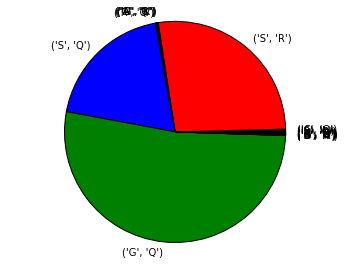

In [11]:
# Firstly, let's plot the proportion of each polymorphism in the dataset.

plt.pie([len(subtypes) for subtypes in polymorphism_subtypes.values()], labels=[polymorphism for polymorphism in polymorphism_subtypes.keys()])
# polymorphism_subtypes[('G', 'K')]
plt.axis('equal')
plt.show()

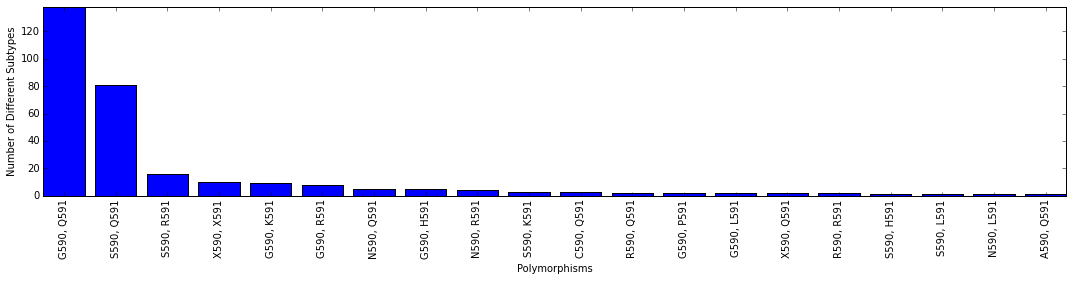

In [12]:
# Let's try a bar chart representation.
fig = plt.figure(figsize=(15, 4))
labels = ['{0}590, {1}591'.format(p[0], p[1]) for p in polymorphism_subtypes.keys()]
# print(labelnums)

heights = []
for sub_year in polymorphism_subtypes.values():
    subtypes = []
    for item in sub_year:
        subtypes.append(item)
    heights.append(len(set(subtypes)))
    
# Gather the labels and heights together.
labels_heights = dict(zip(labels, heights))
labels_heights = sorted(labels_heights.items(), key=lambda x:x[1], reverse=True)
labelnums = list(range(len(labels_heights)))
heights = [h for l, h in labels_heights]
labels = [l for l, h in labels_heights]

plt.bar(labelnums, heights, align='center')
plt.xticks(labelnums, labels, rotation='vertical')
plt.xlabel('Polymorphisms')
plt.axis('tight')
plt.ylabel('Number of Different Subtypes')
plt.savefig('Number of Subtypes Represented by each PB2 590-591 Polymorphism.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

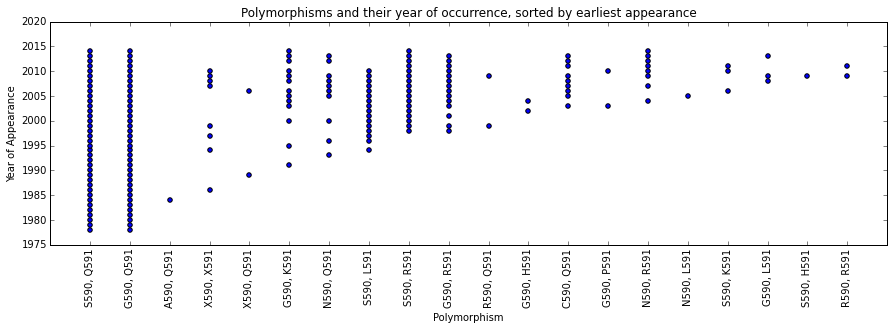

In [13]:
# Let's create a categorical scatter plot to show the years in which each of the polymorphisms are represented.
fig = plt.figure(figsize=(15, 4))
labels = ['{0}590, {1}591'.format(p[0], p[1]) for p, years in sorted(polymorphism_years.items(), key=lambda x:min(x[1]))]

data = []
xpos = []
for i, (polmor, years) in enumerate(sorted(polymorphism_years.items(), key=lambda x:min(x[1]))):
    for year in set(years):
        xpos.append(i)
        data.append(int(year))
# print(set(xpos))      
labelnums = list(set(xpos))
plt.scatter(xpos, data)
plt.xlim(-1, len(labelnums))
plt.xticks(labelnums, labels, rotation='vertical')
plt.xlabel('Polymorphism')
plt.ylabel('Year of Appearance')
plt.title('Polymorphisms and their year of occurrence, sorted by earliest appearance')
plt.savefig('Year of Sghtings of Polymorphisms Earliest for 590-591 positions only.pdf', bbox_inches='tight')
plt.show()

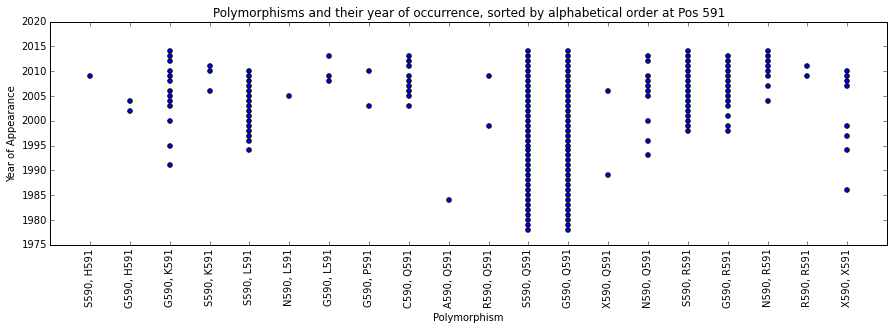

In [14]:
# This is a separate plot sorted in alphabetical order..
fig = plt.figure(figsize=(15, 4))
labels = ['{0}590, {1}591'.format(p[0], p[1]) for p in sorted(polymorphism_years.keys(), key=lambda x:x[1])]

data = []
xpos = []
for i, (polmor, years) in enumerate(sorted(polymorphism_years.items(), key=lambda x:x[0][1])):
    for year in set(years):
        xpos.append(i)
        data.append(int(year))
# print(set(xpos))      
labelnums = list(set(xpos))
plt.scatter(xpos, data)
plt.xlim(-1, len(labelnums))
plt.xticks(labelnums, labels, rotation='vertical')
plt.xlabel('Polymorphism')
plt.ylabel('Year of Appearance')
plt.title('Polymorphisms and their year of occurrence, sorted by alphabetical order at Pos 591')
plt.savefig('Year of Sightings of Polymorphisms Alphabetical for 590-591 positions only.pdf', bbox_inches='tight')
plt.show()

In [14]:
# Next up, let's see what the distribution of subtypes is for each polymorphism.
with open('Polymorphisms and Subtypes 590-591 only.txt', 'w+') as f:
    for polmor, subtypes_years in sorted(polymorphism_subtypes.items(), key=lambda x:len(set(x[1])), reverse=True):
        subtypes = [item for item in subtypes_years]
        print(polmor, set(subtypes))
    
        f.write('Polymorphism {0}590, {1}591:\n'.format(polmor[0], polmor[1]))
        for subtype in set(subtypes):
            if list(set(subtypes)).index(subtype) != len(set(subtypes)) - 1:
                f.write('{0}, '.format(subtype))
            
            if list(set(subtypes)).index(subtype) == len(set(subtypes)) - 1:
                f.write('{0}'.format(subtype))
                f.write('\n\n')

(('G', 'Q'), set(['N5', 'H10N8', 'H10N9', 'H10N1', 'H10N2', 'H10N3', 'H10N4', 'H10N5', 'H10N6', 'H10N7', 'H6N3', 'H2N4', 'H2N5', 'H2N6', 'H2N7', 'H2N1', 'H2N2', 'H2N3', 'H2N8', 'H2N9', 'H8N8', 'H6N4', 'H8N6', 'H8N4', 'H8N2', 'H8N3', 'H8N1', 'unknown', 'H9N6', 'H11', 'H12', 'H6N7', 'Mixed', 'H3', 'H1', 'H6', 'H7', 'H4', 'H5', 'H5N7', 'H5N6', 'mixed', 'H5N4', 'H4N6', 'H12N8', 'H4N7', 'H3N9', 'H3N8', 'H11N6', 'H4N4', 'H3N1', 'H3N3', 'H3N2', 'H3N5', 'H3N4', 'H3N7', 'H3N6', 'H4N8', 'H4N9', 'H5N9', 'H5N8', 'H4N2', 'H4N3', 'H5N5', 'H4N1', 'H5N3', 'H5N2', 'H5N1', 'H4N5', 'H6N8', 'H6N9', 'H7N9', 'H7N8', 'H7N5', 'H6N1', 'H6N2', 'H7N6', 'H7N1', 'H6N5', 'H7N3', 'H7N2', 'H?N4', 'H12N6', 'H12N7', 'N8', 'H15N6', 'H7N4', 'N1', 'N2', 'N3', 'N4', 'H7N7', 'N6', 'N7', 'H1N9', 'H1N8', 'H1N3', 'H1N2', 'H1N1', 'H1N7', 'H1N6', 'H1N5', 'H1N4', 'H9N3', 'H9N2', 'H9N1', 'H9N7', 'H6N6', 'H9N5', 'H9N9', 'H9N8', 'H11N5', 'H11N7', 'H12N9', 'H11N1', 'H11N3', 'H11N2', 'H12N2', 'H12N3', 'H12N1', 'H11N9', 'H11N8', 'H12N4

In [15]:
# Similarly, let's see what hosts are associated with each polymorphism
# Next up, let's see what the distribution of subtypes is for each polymorphism.
with open('Polymorphisms and Hosts 590-591 only.txt', 'w+') as f:
    for polmor, hosts in sorted(polymorphism_hosts.items(), key=lambda x:len(set(x[1])), reverse=True):
        print(polmor, hosts)
        hosts = list(set(hosts))
        f.write('Polymorphism {0}590, {1}591:\n'.format(polmor[0], polmor[1]))
        for host in hosts:
            if hosts.index(host) != len(hosts) - 1:
                f.write('{0}, '.format(host))
            
            if hosts.index(host) == len(hosts) - 1:
                f.write('{0}'.format(host))
                f.write('\n\n')

(('G', 'Q'), ['Mallard/Avian', 'Muscovy Duck/Avian', 'Ruddy Turnstone/Avian', 'Human', 'Duck/Avian', 'Duck/Avian', 'Duck/Avian', 'Duck/Avian', 'Cinnamon Teal/Avian', 'Human', 'Swine', 'Human', 'Human', 'Duck/Avian', 'Duck/Avian', 'Duck/Avian', 'Duck/Avian', 'Duck/Avian', 'Duck/Avian', 'Duck/Avian', 'Duck/Avian', 'Human', 'Duck/Avian', 'Duck/Avian', 'Mallard/Avian', 'Human', 'Swine', 'Mallard/Avian', 'Swine', 'Avian', 'Red Knot/Avian', 'Turkey/Avian', 'Red Knot/Avian', 'Swine', 'Swine', 'Environment', 'Mallard/Avian', 'Human', 'Openbill Stork/Avian', 'Mallard/Avian', 'Human', 'Mallard/Avian', 'Duck/Avian', 'Chicken/Avian', 'Swine', 'Avian', 'Duck/Avian', 'Green-Winged Teal/Avian', 'Avian', 'American Black Duck/Avian', 'Chicken/Avian', 'Ruddy Turnstone/Avian', 'Human', 'Mallard/Avian', 'Human', 'Mallard/Avian', 'Duck/Avian', 'Human', 'Duck/Avian', 'Chicken/Avian', 'Human', 'Human', 'Human', 'Human', 'Human', 'Avian', 'Northern Pintail/Avian', 'Northern Shoveler/Avian', 'Environment', 'Hu

In [16]:
# Similarly, let's see what years are associated with each polymorphism
with open('Polymorphisms and Years 590-591 only.txt', 'w+') as f:
    for polmor, years in sorted(polymorphism_years.items(), key=lambda x:len(set(x[1])), reverse=True):
        years = sorted(list(set(years)))
        print(polmor, years)
        f.write('Polymorphism {0}590, {1}591:\n'.format(polmor[0], polmor[1]))
        for year in years:
            if years.index(year) != len(years) - 1:
                f.write('{0}, '.format(year))
            
            if years.index(year) == len(years) - 1:
                f.write('{0}'.format(year))
                f.write('\n\n')

(('S', 'Q'), [1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014])
(('G', 'Q'), [1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014])
(('S', 'R'), [1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014])
(('S', 'L'), [1994, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])
(('G', 'R'), [1998, 1999, 2001, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013])
(('G', 'K'), [1991, 1995, 2000, 2003, 2004, 2005, 2006, 2008, 2009, 2010, 2012, 2013, 2014])
(('N', 'Q'), [1993, 1996, 2000, 2005, 2006, 2007, 2008, 2009, 2012, 2013])
(('C', 'Q'), [2003, 2005, 2006,

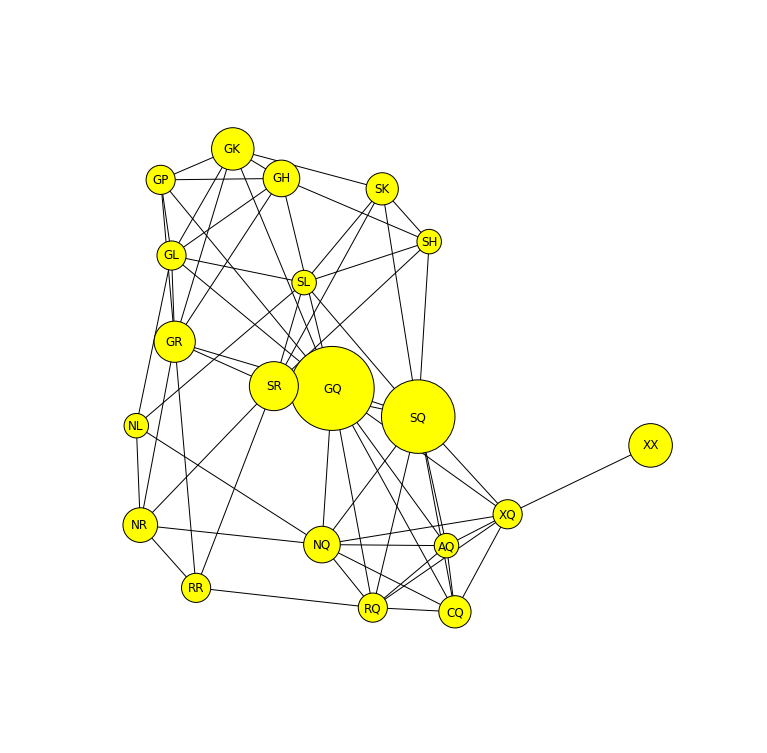

In [17]:
# Create a genotype network

G = nx.Graph()

for polmor, subtypes in polymorphism_subtypes.items():
    p = ''
    for letter in polmor:
        p += letter
        
    G.add_node(p, subtypes=set(subtypes), hosts=polymorphism_hosts[polmor], years=polymorphism_years[polmor])
    
for node1, node2 in combinations(G.nodes(), 2):
    if distance(node1, node2) == 1:
        G.add_edge(node1, node2)
        
fig = plt.figure(figsize=(10,10))
node_sizes = [600 * math.sqrt(len(node[1]['subtypes'])) for node in G.nodes(data=True)]
nx.draw(G, with_labels=True, node_size=node_sizes, node_color ='yellow')
plt.savefig('PB2 Polymorphism Genotype Network 590-591 only.pdf')

In [18]:
# Is node size correlated with the degree centrality of the nodes?
degree_centrality = nx.degree_centrality(G)
degree_centrality

size_dict = {node[0]:len(node[1]['subtypes']) for node in G.nodes(data=True)}
size_dict

{'AQ': 1,
 'CQ': 3,
 'GH': 5,
 'GK': 9,
 'GL': 2,
 'GP': 2,
 'GQ': 138,
 'GR': 8,
 'NL': 1,
 'NQ': 5,
 'NR': 4,
 'RQ': 2,
 'RR': 2,
 'SH': 1,
 'SK': 3,
 'SL': 1,
 'SQ': 81,
 'SR': 16,
 'XQ': 2,
 'XX': 10}

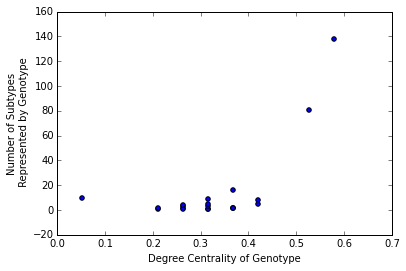

In [19]:
centralities = []
sizes = []
for genotype, centrality in degree_centrality.items():
    centralities.append(centrality)
    sizes.append(size_dict[genotype])
    
plt.scatter(centralities, sizes)
plt.xlabel('Degree Centrality of Genotype')
plt.ylabel('Number of Subtypes \n Represented by Genotype')
plt.savefig('Degree Centrality Scatterplot 590-591 only.pdf')

In [20]:
# What if we created a big, massive scatter table (a table drawn as a scatter plot) with subtypes on the vertical and 
# polymorphism on the horizontal?
polymorphism_subtype_counts = dict()
all_subtypes = set()

for polmor, subtypes in polymorphism_subtypes.items():
    polymorphism_subtype_counts[polmor] = Counter(subtypes)
    for subtype in subtypes:
        all_subtypes.add(subtype)
polymorphism_subtype_counts

{('A', 'Q'): Counter({'H13N6': 1}),
 ('C', 'Q'): Counter({'H5N1': 37, 'H9N2': 7, 'mixed': 1}),
 ('G',
  'H'): Counter({'H1N9': 14, 'mixed': 5, 'H2N9': 5, 'H10N4': 2, 'Mixed': 1}),
 ('G',
  'K'): Counter({'H3N2': 13, 'H1N1': 12, 'H7N9': 6, 'H7N1': 3, 'H5N2': 2, 'H5N1': 2, 'unknown': 1, 'H9N2': 1, 'H1N2': 1}),
 ('G', 'L'): Counter({'H1N1': 2, 'H7N9': 2}),
 ('G', 'P'): Counter({'H4N6': 2, 'H7N3': 1}),
 ('G',
  'Q'): Counter({'H1N1': 2005, 'H3N2': 1765, 'H5N1': 1380, 'H4N6': 797, 'H3N8': 766, 'H9N2': 532, 'mixed': 399, 'H6N2': 391, 'H5N2': 375, 'H10N7': 350, 'H7N3': 329, 'H7N2': 248, 'H6N1': 228, 'H11N9': 223, 'H6N6': 166, 'H7N7': 152, 'H2N3': 144, 'H7N9': 134, 'H1N2': 128, 'H4N8': 120, 'Mixed': 119, 'H8N4': 112, 'H6N8': 112, 'H3N6': 109, 'H12N5': 105, 'H7N1': 104, 'H4N2': 83, 'H11N2': 65, 'H5N3': 59, 'H5N8': 50, 'H6N5': 48, 'H2N9': 37, 'H10N1': 34, 'H2N2': 31, 'H1N3': 31, 'H10N3': 29, 'H2N1': 29, 'H3N1': 29, 'H16N3': 27, 'H10N4': 26, 'H7N6': 26, 'H10N8': 25, 'H13N6': 25, 'H2N7': 24, 'H4N9

In [21]:
(all_subtypes)

{'H1',
 'H10N1',
 'H10N2',
 'H10N3',
 'H10N4',
 'H10N5',
 'H10N6',
 'H10N7',
 'H10N8',
 'H10N9',
 'H11',
 'H11N1',
 'H11N2',
 'H11N3',
 'H11N5',
 'H11N6',
 'H11N7',
 'H11N8',
 'H11N9',
 'H12',
 'H12N1',
 'H12N2',
 'H12N3',
 'H12N4',
 'H12N5',
 'H12N6',
 'H12N7',
 'H12N8',
 'H12N9',
 'H13N2',
 'H13N6',
 'H13N8',
 'H13N9',
 'H14N2',
 'H14N3',
 'H14N5',
 'H14N6',
 'H14N8',
 'H15N2',
 'H15N4',
 'H15N6',
 'H15N8',
 'H15N9',
 'H16N3',
 'H1N1',
 'H1N2',
 'H1N3',
 'H1N4',
 'H1N5',
 'H1N6',
 'H1N7',
 'H1N8',
 'H1N9',
 'H2N1',
 'H2N2',
 'H2N3',
 'H2N4',
 'H2N5',
 'H2N6',
 'H2N7',
 'H2N8',
 'H2N9',
 'H3',
 'H3N1',
 'H3N2',
 'H3N3',
 'H3N4',
 'H3N5',
 'H3N6',
 'H3N7',
 'H3N8',
 'H3N9',
 'H4',
 'H4N1',
 'H4N2',
 'H4N3',
 'H4N4',
 'H4N5',
 'H4N6',
 'H4N7',
 'H4N8',
 'H4N9',
 'H5',
 'H5N1',
 'H5N2',
 'H5N3',
 'H5N4',
 'H5N5',
 'H5N6',
 'H5N7',
 'H5N8',
 'H5N9',
 'H6',
 'H6N1',
 'H6N2',
 'H6N3',
 'H6N4',
 'H6N5',
 'H6N6',
 'H6N7',
 'H6N8',
 'H6N9',
 'H7',
 'H7N1',
 'H7N2',
 'H7N3',
 'H7N4',
 'H7N5',
 

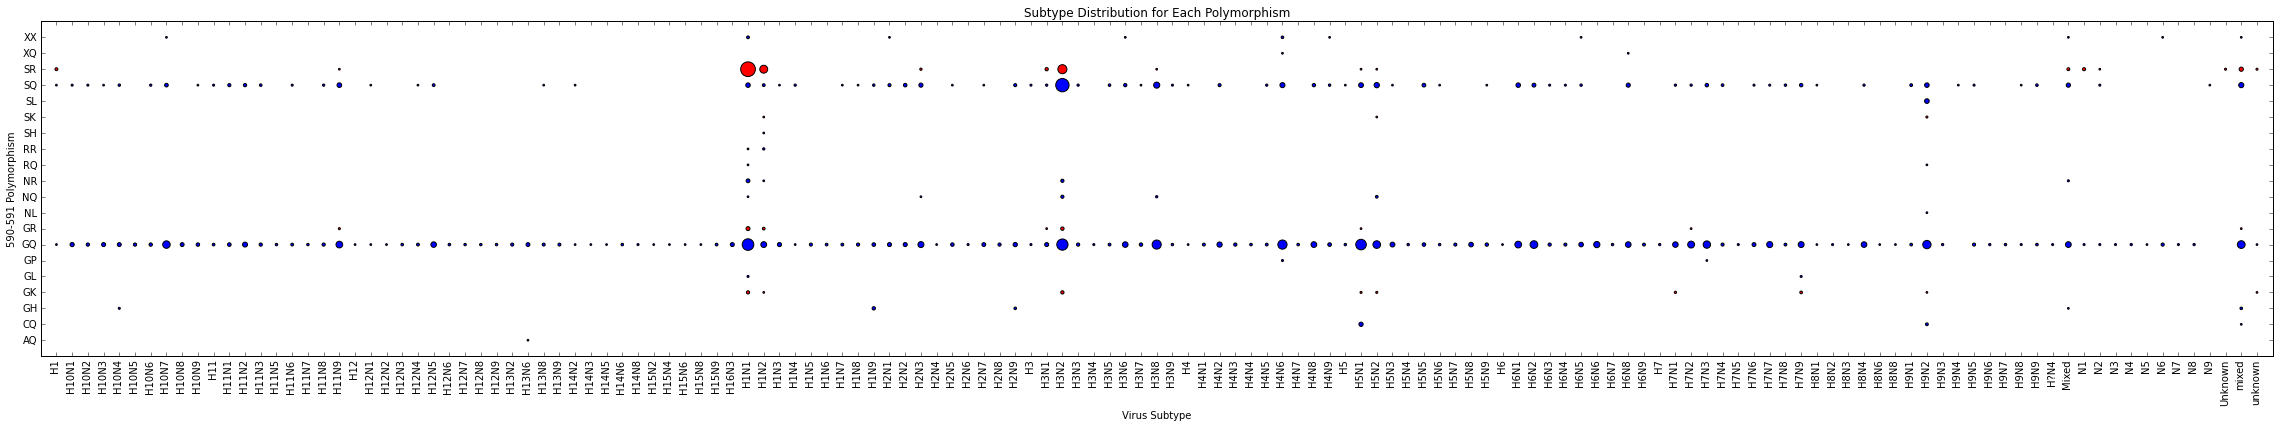

In [22]:
# Based on the dictionary, create the data matrix. 
scatter_ypos = [] # the subtypes
scatter_xpos = [] # the polymorphisms
scatter_size = []
scatter_colors = []

polymorphisms = sorted('{0}{1}'.format(p[0], p[1]) for p in polymorphism_subtype_counts.keys())
subtype_labels = sorted(all_subtypes)
for polmor, counter in polymorphism_subtype_counts.items():
    polmor = '{0}{1}'.format(polmor[0], polmor[1])
    for subtype, count in counter.items():
        scatter_ypos.append(polymorphisms.index(polmor))
        scatter_xpos.append(subtype_labels.index(subtype))
        scatter_size.append(3*math.sqrt(count))
        
        if polmor in ['GK', 'SK', 'GR', 'SR']:
            scatter_colors.append('r')
        else:
            scatter_colors.append('b')
plt.figure(figsize=(40,6))
plt.scatter(scatter_xpos, scatter_ypos, s=scatter_size, c=scatter_colors)
plt.xlim(-1, len(subtype_labels))
plt.ylim(-1, len(polymorphisms))
plt.yticks(range(len(polymorphisms)), polymorphisms)
plt.xticks(range(len(subtype_labels)), subtype_labels, rotation='vertical')
plt.xlabel('Virus Subtype')
plt.ylabel('590-591 Polymorphism')
plt.title('Subtype Distribution for Each Polymorphism')
plt.savefig('Subtype Distribution for each Polymorphism.pdf', bbox_inches='tight')
plt.show()

In [35]:
# What about the distribution of K591 in H3 subtypes? Is it in a human isolate?
for key, vals in polymorphism_subtypes_host.items():
    if key[1] == 'K':
        for val in vals:
            if val[0] == 'H3N2':
                print(val)

('H3N2', 'Swine', 'AB620196')
('H3N2', 'Swine', 'AB434365')
('H3N2', 'Swine', 'KJ880931')
('H3N2', 'Swine', 'KJ880939')
('H3N2', 'Swine', 'KJ880955')
('H3N2', 'Swine', 'AB620188')
('H3N2', 'Swine', 'KJ880947')
('H3N2', 'Swine', 'AB434349')
('H3N2', 'Swine', 'AB434341')
('H3N2', 'Swine', 'FJ561057')
('H3N2', 'Swine', 'KC841925')
('H3N2', 'Swine', 'KC859211')
('H3N2', 'Human', 'KJ623706')
